In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
import seaborn as sns
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 20
pd.options.display.float_format = '{:.1f}'.format

In [2]:
df = pd.read_csv("./train.csv", sep=",")

/home/rainbowww5/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


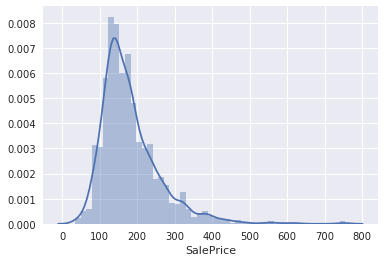

In [3]:
df = df.reindex(
    np.random.permutation(df.index))
df['SalePrice'] /= 1000.0
df.describe()
sns.distplot(df['SalePrice']);

In [4]:
#missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing = missing_data[missing_data["Total"] > 0].copy()
missing

,Total,Percent
PoolQC,1453,1.0
MiscFeature,1406,1.0
Alley,1369,0.9
Fence,1179,0.8
FireplaceQu,690,0.5
LotFrontage,259,0.2
GarageCond,81,0.1
GarageType,81,0.1
GarageYrBlt,81,0.1
GarageFinish,81,0.1


In [5]:

correlation_dataframe = df.copy()
correlation_dataframe["target"] = correlation_dataframe["SalePrice"]
cordf = correlation_dataframe.corr()
picked = cordf[cordf["SalePrice"] > 0.5].copy()
picked = picked["SalePrice"].sort_values()
picked

YearRemodAdd   0.5
YearBuilt      0.5
TotRmsAbvGrd   0.5
FullBath       0.6
1stFlrSF       0.6
TotalBsmtSF    0.6
GarageArea     0.6
GarageCars     0.6
GrLivArea      0.7
OverallQual    0.8
SalePrice      1.0
target         1.0
Name: SalePrice, dtype: float64

/home/rainbowww5/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


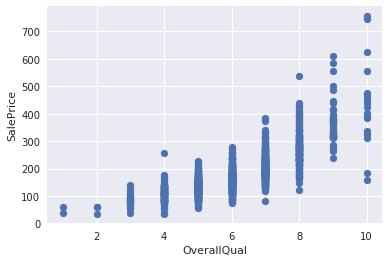

In [6]:
plt.scatter(df['OverallQual'], df['SalePrice'])
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.show()

/home/rainbowww5/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


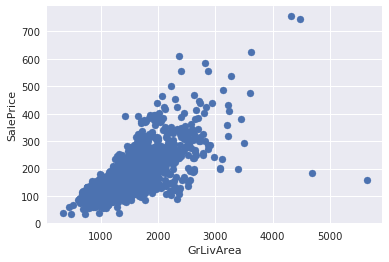

In [7]:
plt.scatter(df['GrLivArea'], df['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

/home/rainbowww5/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


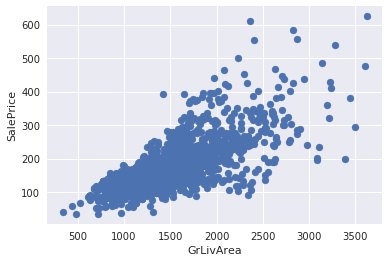

In [8]:
df = df[df.GrLivArea < 4000]
plt.scatter(df['GrLivArea'], df['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

In [9]:
def preprocess_features(df):
    selected_features = df[[
        "YearRemodAdd",
        "YearBuilt",
        "TotRmsAbvGrd",
        "OverallQual",
        "GrLivArea",
        "GarageCars",
        "GarageArea",
        "TotalBsmtSF",
        "1stFlrSF",
        "FullBath"
    ]]
    processed_features = selected_features.copy()
    return processed_features

def preprocess_targets(df):
    output_targets = pd.DataFrame()
    output_targets["SalePrice"] = df["SalePrice"]
    return output_targets

In [10]:
training_examples = preprocess_features(df.head(1170))
training_targets = preprocess_targets(df.head(1170))

validation_examples = preprocess_features(df.tail(290))
validation_targets = preprocess_targets(df.tail(290))
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,YearRemodAdd,YearBuilt,TotRmsAbvGrd,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath
count,1170.0,1170.0,1170.0,1170.0,1170.0,1170.0,1170.0,1170.0,1170.0,1170.0
mean,1984.1,1971.1,6.5,6.1,1508.0,1.8,472.0,1048.2,1157.1,1.6
std,20.9,29.9,1.6,1.4,491.6,0.7,212.5,415.8,369.0,0.5
min,1950.0,1872.0,2.0,1.0,334.0,0.0,0.0,0.0,334.0,0.0
25%,1965.0,1953.2,5.0,5.0,1137.8,1.0,326.0,796.0,884.0,1.0
50%,1993.0,1972.0,6.0,6.0,1456.0,2.0,479.5,990.0,1086.0,2.0
75%,2003.0,2000.0,7.0,7.0,1786.8,2.0,576.0,1267.8,1377.8,2.0
max,2010.0,2010.0,14.0,10.0,3627.0,4.0,1390.0,3206.0,3228.0,3.0


Validation examples summary:


,YearRemodAdd,YearBuilt,TotRmsAbvGrd,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath
count,290.0,290.0,290.0,290.0,290.0,290.0,290.0,290.0,290.0,290.0
mean,1987.7,1971.6,6.4,6.2,1498.2,1.8,468.6,1060.4,1156.1,1.6
std,19.4,31.3,1.6,1.4,515.9,0.7,209.7,395.4,369.4,0.6
min,1950.0,1880.0,3.0,3.0,605.0,0.0,0.0,0.0,483.0,0.0
25%,1972.0,1954.2,5.0,5.0,1100.0,1.0,341.5,789.0,874.5,1.0
50%,1997.0,1976.0,6.0,6.0,1471.0,2.0,476.5,1002.0,1082.5,2.0
75%,2004.0,2002.0,7.0,7.0,1732.0,2.0,576.0,1359.5,1443.0,2.0
max,2010.0,2009.0,12.0,10.0,3493.0,3.0,1220.0,2078.0,2515.0,3.0


Training targets summary:


,SalePrice
count,1170.0
mean,179.9
std,76.9
min,34.9
25%,129.5
50%,162.9
75%,213.5
max,625.0


Validation targets summary:


,SalePrice
count,290.0
mean,181.1
std,75.4
min,37.9
25%,131.6
50%,164.4
75%,214.2
max,538.0


In [11]:
def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

In [12]:
# my_feature = df[['LotArea']]
# feature_columns = [tf.feature_column.numeric_column("LotArea")]

In [13]:
# targets = df["SalePrice"]

In [14]:
# my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.00001)
# my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# linear_regressor = tf.estimator.LinearRegressor(
#     feature_columns=feature_columns,
#     optimizer=my_optimizer
# )

In [15]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

def test_input_fn(features, batch_size=1, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    features = ds.make_one_shot_iterator().get_next()
    return features

In [16]:
# _ = linear_regressor.train(
#     input_fn = lambda: my_input_func(my_feature, targets),
#     steps=100
# )

In [17]:
def find_na(df):
    l = []
    for label in df.columns:
        if df[label].dropna().shape[0] != df.shape[0]:
            l.append(label)
    return l

In [18]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
    
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["SalePrice"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["SalePrice"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["SalePrice"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 157.88
  period 01 : 121.34
  period 02 : 87.56
  period 03 : 61.28
  period 04 : 54.01
  period 05 : 53.76
  period 06 : 54.66
  period 07 : 53.76
  period 08 : 54.01
  period 09 : 53.76
Model training finished.


/home/rainbowww5/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


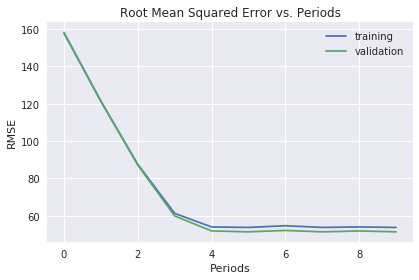

In [19]:
minimal_features = [
   "GrLivArea",
    "OverallQual",
]

assert minimal_features, "You must select at least one feature!"

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

my_model = train_model(
    learning_rate=0.001,
    steps=50,
    batch_size=100,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

In [20]:
def my_test_input_fn(features, batch_size=1, shuffle=True, num_epochs=None):
   # Convert pandas data into a dict of np arrays.
   features = {key:np.array(value) for key,value in dict(features).items()}                                          
   
   # Construct a dataset, and configure batching/repeating.
   ds = Dataset.from_tensor_slices((features)) # warning: 2GB limit
   ds = ds.batch(batch_size).repeat(num_epochs)

   # Shuffle the data, if specified.
   if shuffle:
       ds = ds.shuffle(10000)
   
   # Return the next batch of data.
   features = ds.make_one_shot_iterator().get_next()
   return features


test_data = pd.read_csv("test.csv", sep=",")

In [21]:
test_examples = preprocess_features(test_data)
predict_test_input_fn = lambda: my_test_input_fn(
       test_examples,
      num_epochs=1,
       shuffle=False)

test_predictions = my_model.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])
test_predictions = [x * 1000 for x in test_predictions]
test_predictions
#test_predictions

[107533.79058837891,
 159498.01635742188,
 195498.09265136719,
 192499.61853027344,
 153621.09375,
 198619.91882324219,
 142457.18383789062,
 175818.81713867188,
 160939.77355957031,
 105852.02026367188,
 160459.74731445312,
 118456.00891113281,
 131054.94689941406,
 174738.75427246094,
 100336.80725097656,
 280108.97827148438,
 185302.64282226562,
 203785.24780273438,
 218664.27612304688,
 323551.08642578125,
 270026.79443359375,
 164421.630859375,
 158897.97973632812,
 137418.62487792969,
 164899.96337890625,
 207982.07092285156,
 297028.10668945312,
 191422.94311523438,
 146179.06188964844,
 176178.8330078125,
 199101.63879394531,
 121454.4677734375,
 179298.98071289062,
 281907.37915039062,
 267026.64184570312,
 178580.64270019531,
 201621.76513671875,
 144018.95141601562,
 144018.95141601562,
 148337.46337890625,
 181459.09118652344,
 129618.24035644531,
 170181.90002441406,
 221784.423828125,
 179060.6689453125,
 219500.94604492188,
 299424.86572265625,
 226941.29943847656,
 1974

In [27]:
my_submission = pd.DataFrame({'PassengerId': test_data.Id, 'Survived': test_predictions})
# you could use any filename. We choose submission here
my_submission.to_csv('submission_12345.csv', index=False)

In [28]:
finaldf = pd.read_csv("./submission_12345.csv", sep=",")
finaldf

,PassengerId,Survived
0,1461,107533.8
1,1462,159498.0
2,1463,195498.1
3,1464,192499.6
4,1465,153621.1
5,1466,198619.9
6,1467,142457.2
7,1468,175818.8
8,1469,160939.8
9,1470,105852.0


In [26]:
find_na(finaldf)

[]